<a href="https://colab.research.google.com/github/nik1806/Semantic-segmentation/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# Load the data and organizing it 
# root_dir = 'drive/My Drive/'
# data_dir = root_dir + 'NN_pro_data'

In [3]:
# change directory
# import os
# os.chdir(data_dir)
# !ls

In [4]:
# unzip data 
#!unzip gtFine_trainvaltest.zip
# !unzip leftImg8bit_trainvaltest.zip

In [5]:
# !ls

In [6]:
# Insert the directory - FOR importing user-defined modules/packages
# import sys
# sys.path.insert(0,'/content/drive/My Drive/Semantic-segmentation')

### Import libraries

In [8]:
# from dataset import cityscapes_train
# from dataset import cityscapes_val
from torchvision import transforms
from torchvision.datasets import Cityscapes
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

### Dataset reader 

In [9]:
from utils.custom_transforms import pair_transform_train, pair_transform_val
data_dir = '../datasets/cityscapes/'

In [10]:
dst_train = Cityscapes(data_dir, split='train', mode='fine', target_type='semantic', transforms=pair_transform_train) # data_dir
dst_val = Cityscapes(data_dir, split='val', mode='fine', target_type='semantic', transforms=pair_transform_val)

In [11]:
# data length
length_train = len(dst_train)
length_val = len(dst_val)
print(length_train)
print(length_val)

2975
500


### Visualize the data

In [12]:
from utils.custom_transforms import unNormalize

(-0.5, 255.5, 255.5, -0.5)

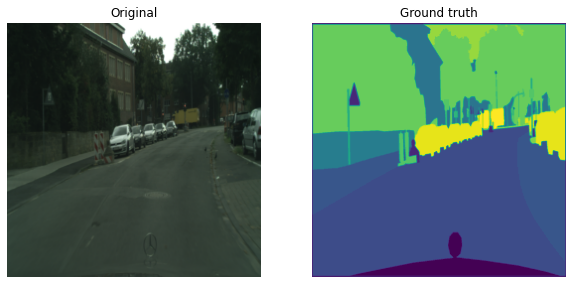

In [13]:
# Verifying transformations (Especially consistancy among image and segmentation map)

# img, segmap = dst_train[16]
img, segmap = dst_val[21]

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1)
img = img.data.numpy() # data in image and current form of matrix
img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
plt.title('Original')
plt.imshow(img) # original
plt.axis('off')

# ground truth
fig.add_subplot(1, 2, 2)
label = segmap.data.numpy() # data in image and current form of matrix
# label = decode_segmap(label)
plt.title('Ground truth')
plt.imshow(label) 
plt.axis('off')

In [7]:
np.unique(label)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

### Dataloader

In [8]:
bs = 12
cls_num = 19
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

In [9]:
# dataiter = iter(train_loader)
# #print(dataiter.next())
# (images, labels) = dataiter.next()

# dataiter_val = iter(val_loader)
# (images_val, labels_val) = dataiter_val.next()
# labels_val.shape

### Model

In [10]:
from models.networkT2 import R2UNet

In [11]:
device = torch.device("cuda:1")
model = R2UNet(in_channels=3,n_classes=cls_num).to(device)

### Hyper parameters

In [12]:
epochs = 1
lr = 3e-4
wdk = 1e-4

In [13]:
from torch.optim import Adam, lr_scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk) 

### Training model

In [20]:
loss_train = []
loss_val = []

for epoch in range(epochs):
    #Training
    model.train()
    running_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        inputs = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)

     
    #loss = criterion(outputs,targets[:,0])
        #loss = criterion(outputs,labels[:,0].long())
        # loss = criterion(outputs,labels.long())
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        ###accumulating loss for each batch
        running_loss += loss.item()

        if i%40 == 0:
            print("Epoch{}, iter{}, running loss: {}".format(epoch, i, running_loss/(bs*(i+1))))
                  
    loss_train.append(running_loss/len(train_loader))

    print("Epoch{}, Training loss: {}".format(epoch, running_loss/len(train_loader)))
    torch.save(model.state_dict(), f'weights/T2/epoch_{epoch}.pth')

    #Validation
    model.eval()
    running_loss_val = 0
    for i, (images, labels) in enumerate(val_loader):
        inputs = images.to(device)
        labels = labels.to(device)
        # labels = labels.squeeze(1)
             
        with torch.no_grad(): 
            outputs = model(inputs)
            # loss = criterion(outputs,labels.long())
            loss = criterion(outputs,labels)

            ###accumulating loss for each batch
            running_loss_val += loss.item()


        #if i%10 == 0:
    loss_val.append(running_loss_val/len(val_loader))
    print("Epoch{}, Validation loss: {}".format(epoch, running_loss_val/len(val_loader)))


epoch0, iter0, loss: 0.30524611473083496
epoch0, iter40, loss: 0.17603462546821533
epoch0, iter80, loss: 0.14490198721120387
epoch0, iter120, loss: 0.13080722192102226
epoch0, iter160, loss: 0.12290322277733505
epoch0, iter200, loss: 0.11705484561263824
epoch0, iter240, loss: 0.11221537301072111
epoch0, loss: 1.3380299282650794
epoch0, loss: 1.6123527146521068


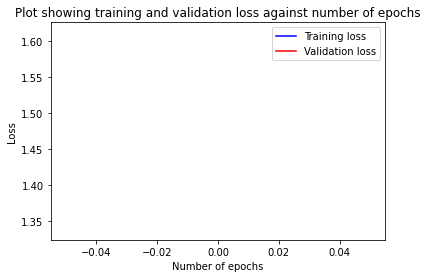

In [21]:
# x = [i for i in range(len(train_loader))]
X = range(epochs)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(len(loss_train)), loss_train, color='b', label='Training loss')
plt.plot(np.arange(len(loss_val)), loss_val, color='r', label='Validation loss')
plt.legend()
plt.savefig('results/T2_loss_curves.png', bbox_inches='tight')
plt.show()
# plt.plot()

### Evaluation and plotting 


In [1]:
#5 evaluation matrices to be used: sensitivity, specificity, accuracy, AUC, and DC
from utils.eval_metrics import dice_coefficient_custom, roc_auc_custom, accuracy_se_sp_custom, sensitivity_custom, specificity_custom# user defined
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, multilabel_confusion_matrix

def evaluate_batch(gnd_b, pred_b, cls:int = 34):
    """
        Calculate evalution scores over the batch.
    Args:   
        gnd_b: BxHxW tensor; ground truth labels; each element of matrix in B dim contains class label from (0-20)
        pred_b: BxCxHxW tensor; each element contains predicted class label 
                here C=21 (0-20; no. of classes); each C corresponds to probabilites for that class,
                eg. C=0 contain score at each element in matrix HxW 
    Return:
        f1_score, auc_score, dice_coeeficient (averaged over batch size)
    """
    # to cpu and as numpy ndarray
    gnd_b = gnd_b.cpu()

    batch_size = gnd_b.shape[0]
    
    # extract most probable class through C-dim 
    label_b = torch.argmax(pred_b, dim=1).cpu()
    sensitivity = specificity = accuracy = auc = dice = 0
    # iterate over batch elements
    for i in range(batch_size):
        gnd = gnd_b[i,:,:] 
        label = label_b[i,:,:]
        #f1 += f1_score(gnd.flatten(), label.flatten(), average='micro')
        #sensitivity += sensitivity_custom(gnd, label)
        
        
        #specificity += specificity_custom(gnd, label)
        #accuracy += accuracy_se_sp_custom(gnd, label)
        temp = accuracy_se_sp_custom(gnd, label)
        accuracy += temp[0]
        sensitivity += temp[1]
        specificity += temp[2]
        # auc += roc_auc_score(gnd.flatten(), label.flatten(), average='micro', multi_class='ovr')
        auc += roc_auc_custom(gnd.numpy(), label.numpy(), cls, average='micro')
        dice += dice_coefficient_custom(gnd.numpy(), label.numpy(), cls)

    return [sensitivity/batch_size, specificity/batch_size, accuracy/batch_size, auc/batch_size, dice/batch_size]

19.856825661570106 3.0525030513849195e-05 13.005948545609021 11.985548135770077 4.576102834493221


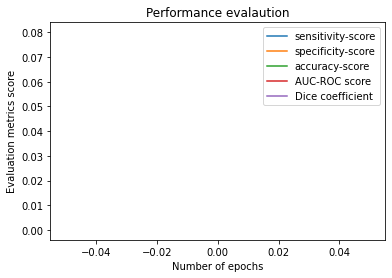

In [17]:
# list of score 
sensitivity_list = []
specificity_list = []
accuracy_list = []
auc_list = []
dice_list = []

# move model to gpu
model = model.to(device)
# loop for original number of epochs
for i in range(epochs):
    # load the model states
    model.load_state_dict(torch.load(f'../weights/T2/epoch_{i}.pth'))
    # model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
    model.eval()
    # evaluation score variables to store values over each epoch
    sensitivity_score = specificity_score = accuracy_score = auc_score = dice_score = 0


    for img, label in val_loader:
        img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
            # output of model is orderedDict
#             pred = pred['out'] # Batchx21(class)xHxW
            # evaluation
            scores = evaluate_batch(label, pred, cls=cls_num)
            # sum values
            sensitivity_score += scores[0]
            specificity_score += scores[1]
            accuracy_score += scores[2]
            auc_score += scores[3]
            dice_score += scores[4]
    
        # break

    print(sensitivity_score/len(val_loader), specificity_score/len(val_loader), accuracy_score/len(val_loader), auc_score/len(val_loader), dice_score/len(val_loader))
    # append to list (with averaged values over valid set)
    sensitivity_list.append(sensitivity_score/len(val_loader))
    specificity_list.append(specificity_score/len(val_loader))
    accuracy_list.append(accuracy_score/len(val_loader))
    auc_list.append(auc_score/len(val_loader))
    dice_list.append(dice_score/len(val_loader))



In [ ]:
# PLOT
X = range(epochs)
plt.plot(X, sensitivity_list, label="sensitivity-score")
plt.plot(X, specificity_list, label="specificity-score")
plt.plot(X, accuracy_list, label="accuracy-score")
plt.plot(X, auc_list, label="AUC-ROC score")
plt.plot(X, dice_list, label="Dice coefficient")
plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T2_eval_metrics.png', bbox_inches='tight')
plt.show()